In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
import pandas as pd
import graphviz
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint

/Users/nikitavemuri/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nikitavemuri/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
np.random.seed(0)

# Decision Trees

This notebook will walk through how to use decision trees with bagging and boosting methods in sklearn as well as introduce the bias variance tradeoff.

First load the iris dataset into a pandas dataframe.

In [3]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

We will then add the species label to each datapoint using the encoding given in the dataset to understand what the overall dataset looks like.

In [4]:
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Split the dataframe into training and validation data.

In [5]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]
train = train.drop(['is_train'], axis = 1)
test = test.drop(['is_train'], axis = 1)

Separate the labels and feature from both the training and test datasets and refactorize the labels.

In [6]:
train_features = train[train.columns[:4]]
train_labels = pd.factorize(train['species'])[0]
test_features = test[test.columns[:4]]
test_labels = pd.factorize(test['species'])[0]

Create a basic decision tree which minimizes entropy and fit it to the training data.

In [7]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We can visualize this decision tree by using graphviz. Visualizing a decision tree allows us to easily interpret how the predictions or classifications are made because each split is clearly defined.

Notice how with each split the weighted entropy of the two branches is less than the entropy of the parent.


In [8]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)

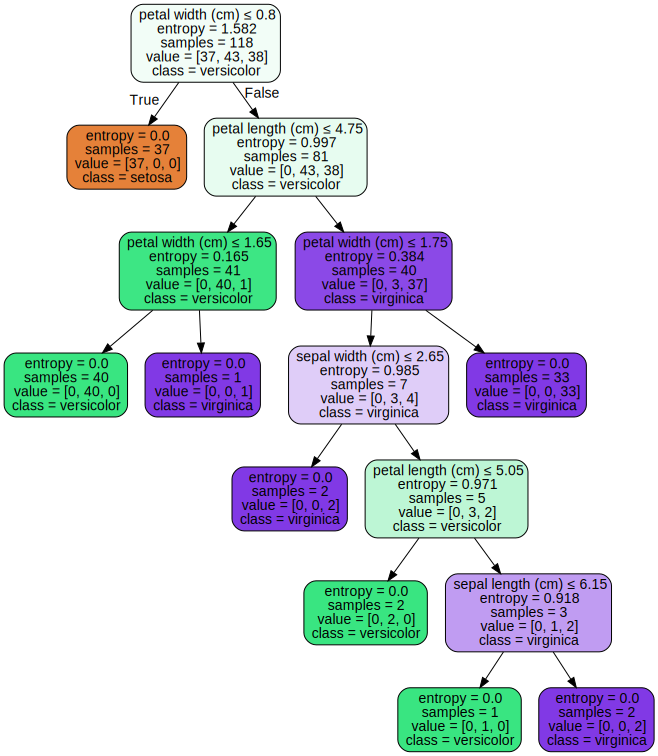

In [9]:
graph = graphviz.Source(dot_data) 
graph

Compute the training and validation accuracies. You should notice the decision tree gets a higher training accuracy than validation. Decision trees have the capability to fit each training point accurately, so if left unregulated the tree will probably end up overfitting to the training set.

In [10]:
clf.score(train_features, train_labels)

1.0

In [11]:
clf.score(test_features, test_labels)

0.9375

We will now use Grid Search to find a good set of hyperparameters which attempt to regualize the tree.

In [12]:
parameters = {"min_samples_split": [2, 10],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }
gridsearch = GridSearchCV(clf, parameters)
gridsearch.fit(train_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 10], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_leaf_nodes': [None, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
best_tree = gridsearch.best_estimator_ 
best_tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Run the following code to visualize the new tree.

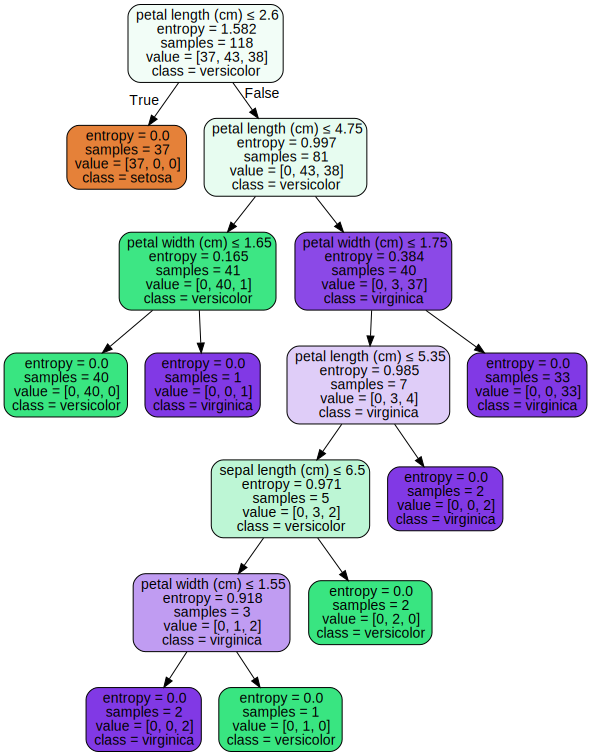

In [14]:
dot_data = tree.export_graphviz(best_tree, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 
graph

You should see that the difference between the validation and training accuracies is not as large as before.

In [15]:
best_tree.score(train_features, train_labels)

1.0

In [16]:
best_tree.score(test_features, test_labels)

0.9375

Now train a Random Forest Classifier on the same dataset. Random forests train multiple strong learners on the same dataset, so we don't have to worry as much about regularizing each individual decision tree as long as there are multiple learners.

In [17]:
clf = RandomForestClassifier(criterion = 'entropy', n_estimators=100)
clf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
clf.score(train_features, train_labels)

1.0

In [19]:
clf.score(test_features, test_labels)

0.9375

Train an AdaBoost Classifier on the same dataset. Boosting trains weak learners sequentially so they focus on the points that are hard to classify, so make sure to limit each individual tree so it is individually weak.

In [20]:
default_tree = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, criterion = 'entropy')

In [21]:
boost_clf = AdaBoostClassifier(base_estimator = default_tree)

In [22]:
boost_clf.fit(train_features, train_labels)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [23]:
boost_clf.score(train_features, train_labels)

1.0

In [24]:
boost_clf.score(test_features, test_labels)

0.96875